In [1]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape,Embedding,Concatenate,Input
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras.utils import plot_model
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import copy
from random import randint
import keras
import time
import math

tf.config.list_physical_devices()

2024-09-30 21:26:39.917003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 21:26:39.933125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 21:26:39.933178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 21:26:39.945496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 21:26:41.054605: W tensorflow/compiler/tf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
rescale = lambda x,y: ((x/255.0) ,y)
preprocess = lambda x,y: ((x-0.5)/0.5 ,y)
rotate = RandomRotation(factor=0.4,name="rotate")
flip = RandomFlip(mode="horizontal_and_vertical",name="flip")
zoom = RandomZoom(height_factor=(-0.2, -0.2), name="zoom")
display_model = lambda x,y: plot_model(x,show_shapes=True,show_layer_names=True,to_file=f'{y}.png',show_layer_activations=True)

2024-09-30 21:26:44.194883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-30 21:26:44.194979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-30 21:26:44.195023: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-30 21:26:44.325641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-30 21:26:44.325737: I external/local_xla/xla/stream_executor

In [3]:
no_of_class = 102
IMG_SIZE = (100,100)
BATCH = 12

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)

train = train.map(rescale)
train = train.map(preprocess)

Found 6552 files belonging to 102 classes.


2024-09-30 21:26:45.653115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


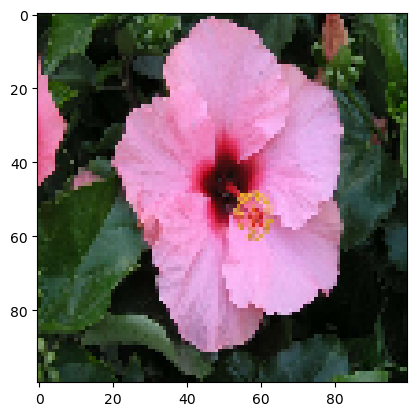

In [4]:
# sampling

for i,j in train.take(1):
    plt.imshow(i[0].numpy()*0.5+0.5)

In [5]:
def discriminator_block(filters:int,name:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=2, padding='same', name=f'Convo_{name}')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(name=f'Leaky_{name}')(x)
    x = Dropout(0.1,name=f'Dropout_{name}')(x)
    
    return x
    
def dense_block(filters:list,input: keras.Layer,start:int) -> keras.Layer:
    
    x = Dense(filters[0],name=f'Dense_{start}',activation='relu')(input)
    
    for i,j in enumerate(filters[1:]):
        x = Dense(j,name=f'Dense_{start+i+1}',activation='relu')(x)
    
    return x
    
def make_discriminator_ac(img: tuple[int],no_of_class:int) -> keras.Model:
    label_input = Input(shape=(1,),name='label_input')
    
    l = Embedding(no_of_class,256,name='label_embedding')(label_input)
    l = Dense(np.prod(img)*3,name='label_dense')(l)
    l = Reshape((img[0], img[1],3),name='label_Reshape')(l)
    
    img_input = Input(shape=(img[0],img[1],3),name='image_input')
    y = rotate(img_input)
    y = zoom(y)
    y = flip(y)
    
    merge = Concatenate(name='concatenate')([y,l])
    
    x = discriminator_block(16,1,merge)
    x = discriminator_block(32,2,x)
    x = discriminator_block(64,3,x)
    x = discriminator_block(128,4,x)
    x = Flatten(name='flatten')(x)
    
    
    label_based = dense_block([256,128],x,1)
    label_based = Dense(no_of_class,activation='softmax',name='label_predict')(label_based)
    
    real_based = dense_block([128,64,32,16,8],x,3)
    real_based = Dense(1, activation='sigmoid',name='real_predict')(real_based)
    
    discriminator = tf.keras.Model([img_input,label_input],[label_based,real_based],name='AC_Discriminator')
    
    return discriminator


In [6]:
make_discriminator_ac(IMG_SIZE,no_of_class).summary()

Model: "AC_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rotate              │ (None, 100, 100,  │          0 │ image_input[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 256)    │     26,112 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zoom (RandomZoom)   │ (None, 100, 100,  │          0 │ rotate[0][0]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 30000)  │  7,710,000 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flip (RandomFlip)   │ (None, 100, 100,  │          0 │ zoom[0][0]        │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 100, 100,  │          0 │ label_dense[0][0] │
│ (Reshape)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 100,  │          0 │ flip[0][0],       │
│ (Concatenate)       │ 6)                │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_1 (Conv2D)    │ (None, 50, 50,    │        880 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 50,    │         64 │ Convo_1[0][0]     │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_1 (LeakyReLU) │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 50, 50,    │          0 │ Leaky_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_2 (Conv2D)    │ (None, 25, 25,    │      4,640 │ Dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        128 │ Convo_2[0][0]     │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_2 (LeakyReLU) │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 25, 25,    │          0 │ Leaky_2[0][0]     │
│                     │ 32)               │            │                 

 Total params: 10,300,839 (39.29 MB)

 Trainable params: 10,300,359 (39.29 MB)

 Non-trainable params: 480 (1.88 KB)

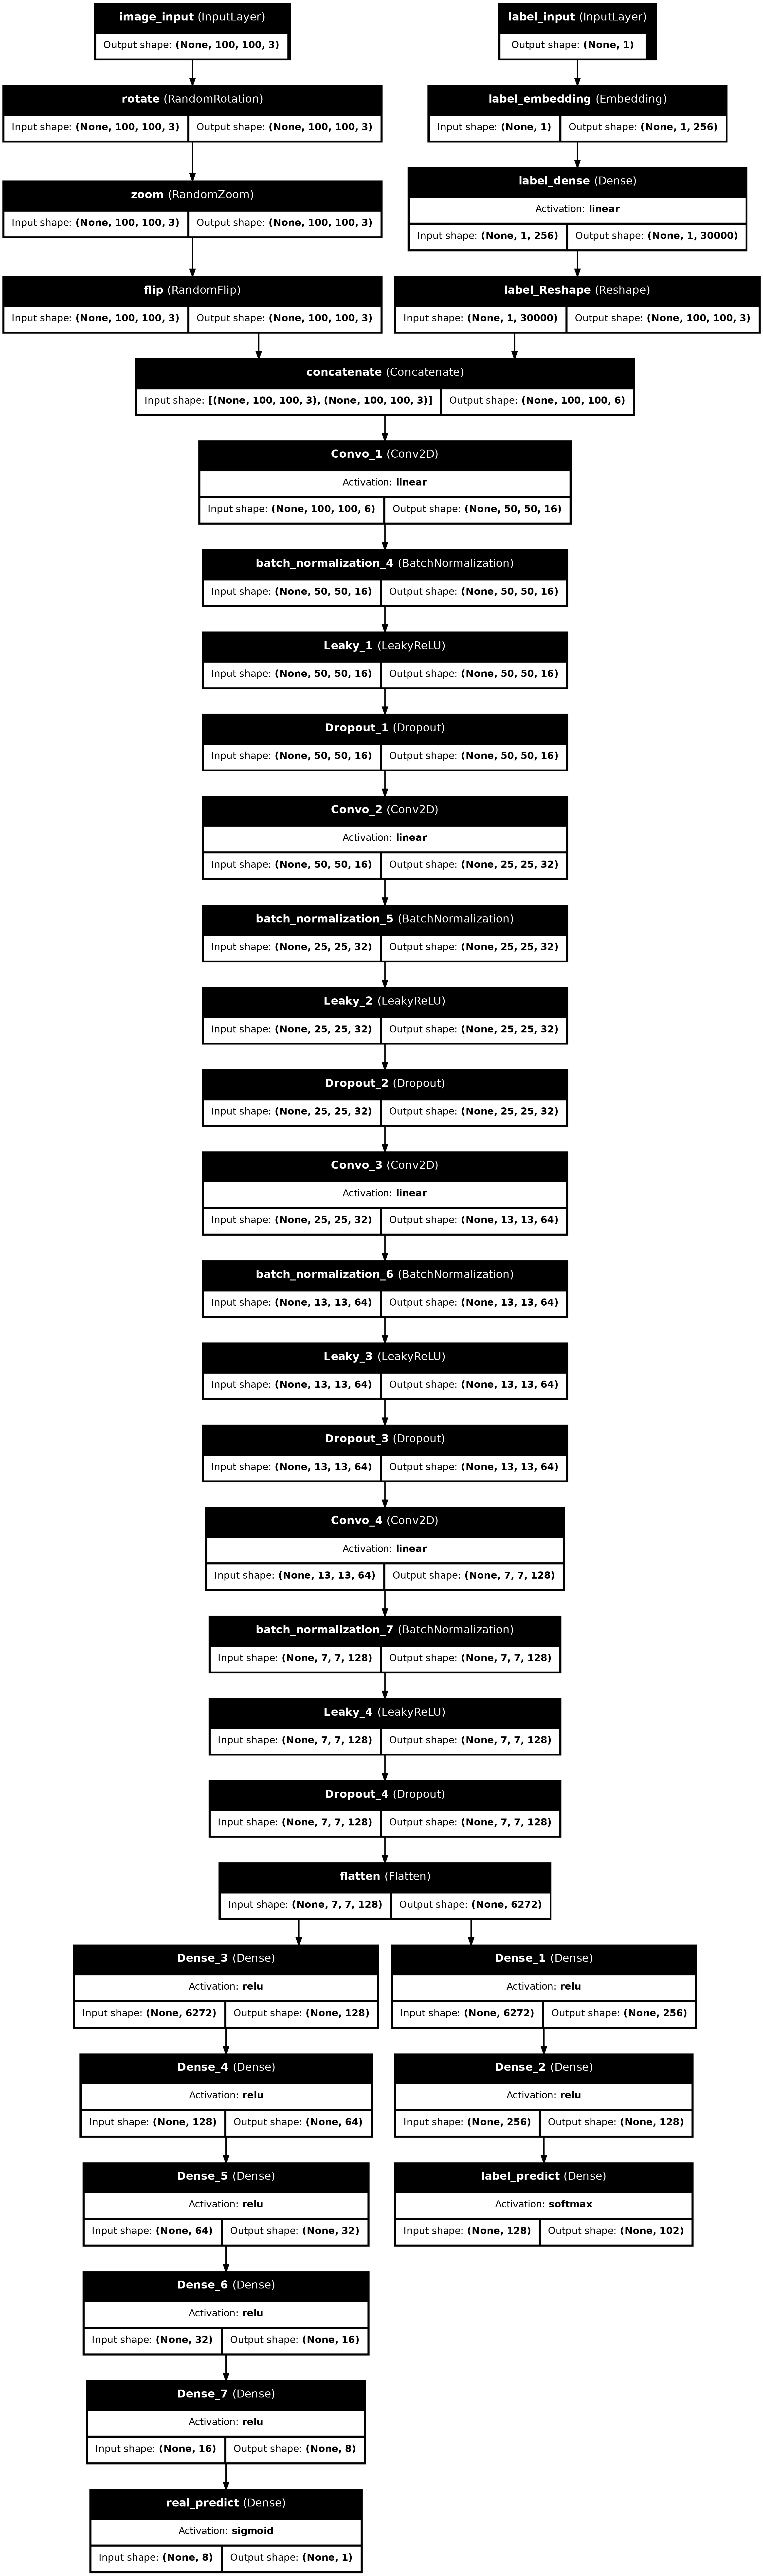

In [7]:
display_model(make_discriminator_ac(IMG_SIZE,no_of_class),'../model_arch/ac_disc')

In [8]:
latent_dim = np.array([10,10,256])
noise_shape = 256

def upsample_block(filters:int,name:int,strides:int,kernel:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2DTranspose(filters,(kernel,kernel),strides=strides,padding='same', name=f'conv_{name}')(input)
    x = BatchNormalization(name=f'norm_{name}')(x)
    x = LeakyReLU(name=f'leaky_{name}')(x)
    
    return x

def make_generator_ac(no_of_class:int,noise_shape:tuple[int],latent_dim:tuple[int]) -> keras.Model:
    
    label_input = Input(shape=(1,),name='label_input')
    l = Embedding(no_of_class,256,name='label_embedding')(label_input)
    l = Dense(np.cumprod(latent_dim)[-2]*3,name='label_dense')(l)
    l = Reshape(np.append(latent_dim[:-1],[3]),name='label_Reshape')(l)
    
    noise_input = Input(shape=(noise_shape,),name='noise_input')
    n = Dense(np.prod(latent_dim),name='noise_dense')(noise_input)
    n = BatchNormalization(name='norm_noise')(n)
    n = LeakyReLU(name='leaky_noise')(n)
    n = Reshape(latent_dim,name='noise_reshape')(n)
    
    merge = Concatenate(name='concatenate')([n,l])
    
    x = upsample_block(filters=512,name=1,strides=2,kernel=3,input=merge)
    x = upsample_block(filters=256,name=2,strides=1,kernel=2,input=x)
        
    x = upsample_block(filters=128,name=3,strides=5,kernel=6,input=x)
    x = upsample_block(filters=64,name=4,strides=1,kernel=2,input=x)
    
    x = Conv2DTranspose(3,(3,3),strides=1,padding='same', name='final',activation='tanh')(x)
    
    generator = tf.keras.Model([noise_input,label_input],x,name='AC_Generator')
    
    return generator

In [9]:
make_generator_ac(no_of_class,noise_shape,latent_dim).summary()

Model: "AC_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_dense (Dense) │ (None, 25600)     │  6,579,200 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_noise          │ (None, 25600)     │    102,400 │ noise_dense[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 256)    │     26,112 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_noise         │ (None, 25600)     │          0 │ norm_noise[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 300)    │     77,100 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_reshape       │ (None, 10, 10,    │          0 │ leaky_noise[0][0] │
│ (Reshape)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 10, 10, 3) │          0 │ label_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ noise_reshape[0]… │
│ (Concatenate)       │ 259)              │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1              │ (None, 20, 20,    │  1,193,984 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 20, 20,    │      2,048 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_1 (LeakyReLU) │ (None, 20, 20,    │          0 │ norm_1[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2              │ (None, 20, 20,    │    524,544 │ leaky_1[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 20, 20,    │      1,024 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_2 (LeakyReLU) │ (None, 20, 20,    │          0 │ norm_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3              │ (None, 100, 100,  │  1,179,776 │ leaky_2[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,721,519 (37.08 MB)

 Trainable params: 9,668,399 (36.88 MB)

 Non-trainable params: 53,120 (207.50 KB)

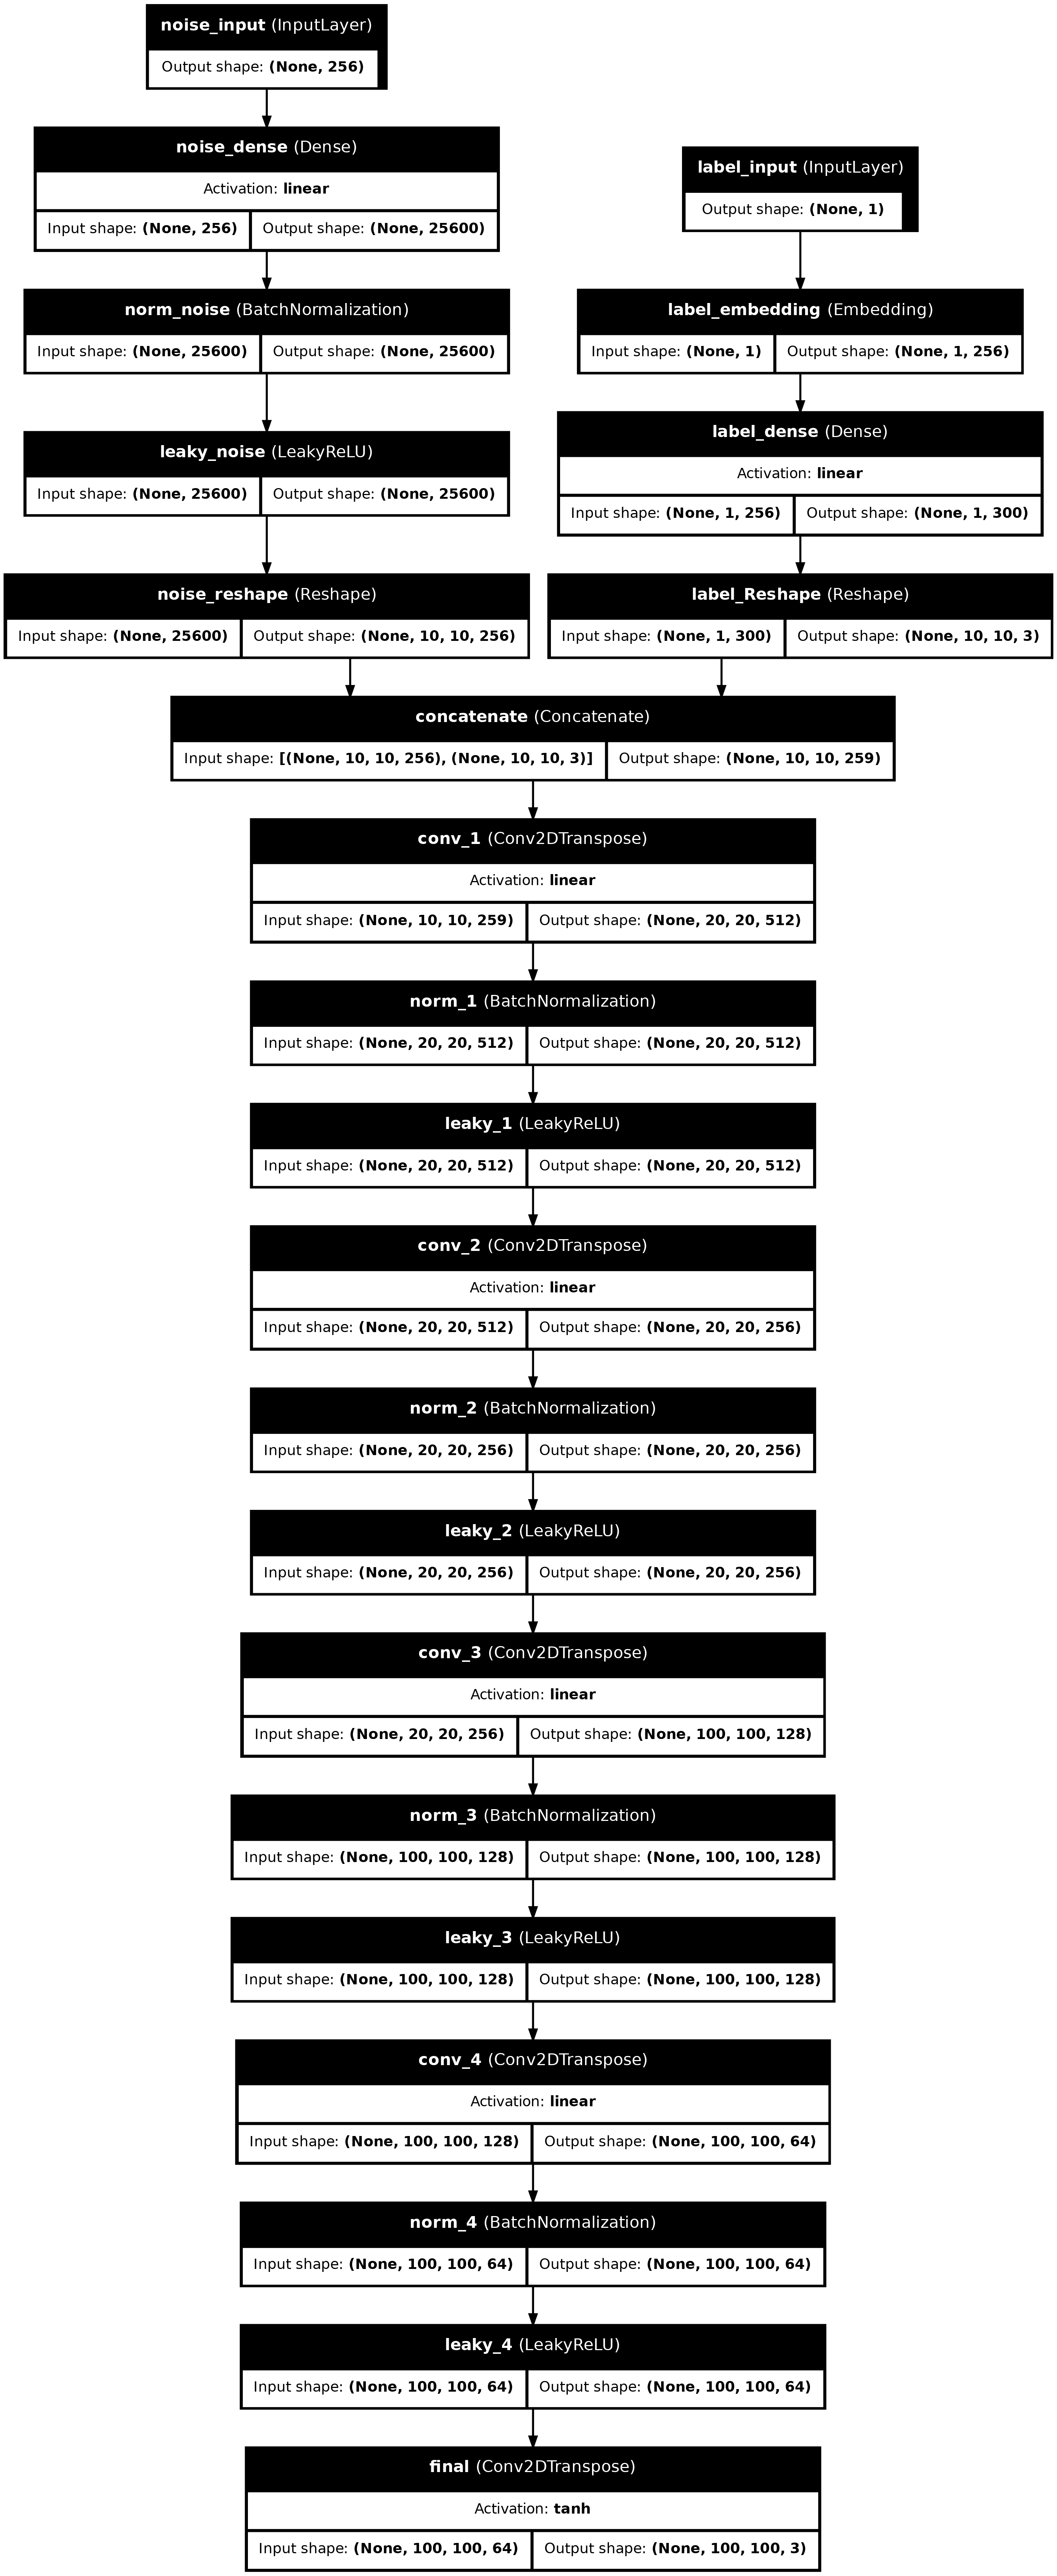

In [10]:
display_model(make_generator_ac(no_of_class,noise_shape,latent_dim),'../model_arch/ac_gen')

In [11]:
class Discriminator(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(Discriminator,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.discriminator = make_discriminator_ac(self.img,no_of_class)
        self.real_loss = tf.keras.metrics.Mean(name="real_loss")
        self.class_loss = tf.keras.metrics.Mean(name="class_loss")
        
    @property
    def metrics(self):
        return [self.real_loss,self.class_loss]
        
    def compile(self,dis_opt,class_loss_func,real_loss_func):
        super(Discriminator,self).compile()
        self.dis_opt = dis_opt
        self.class_loss_func = class_loss_func
        self.real_loss_func = real_loss_func
            
    def train_step(self,image):
        img, label = image
        label = tf.expand_dims(label,axis=-1)
        
        with tf.GradientTape() as disc_tape:
            class_, real = self.discriminator([img,label])
            class_loss = self.class_loss_func(label,class_)
            real_loss = self.real_loss_func(real)
            
            total_loss = class_loss + real_loss
        
        graident_total = disc_tape.gradient(total_loss,self.discriminator.trainable_weights)
            
        self.dis_opt.apply_gradients(zip(graident_total,self.discriminator.trainable_weights))

        self.real_loss.update_state(real_loss)
        self.class_loss.update_state(class_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):        
        try:
            self.discriminator.save('../saved_weights/acgan/dis.keras')
            print('Saved the discriminator')
        except:
            print('Error saving the discriminator')
            
    def load_model(self):        
        try:
            self.discriminator.load_weights('../saved_weights/acgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
                

In [13]:
class AC_GAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(AC_GAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.generator = make_generator_ac(no_of_class,self.noise_shape,self.latent_shape)
        self.discriminator = make_discriminator_ac(self.img,no_of_class)
        self.gen_real_loss = tf.keras.metrics.Mean(name="generator_real_loss")
        self.gen_class_loss = tf.keras.metrics.Mean(name="generator_class_loss")
        self.dis_real_loss = tf.keras.metrics.Mean(name="discriminator_real_loss")
        self.dis_class_loss = tf.keras.metrics.Mean(name="discriminator_class_loss")
        
    @property
    def metrics(self):
        return [self.gen_real_loss,self.gen_class_loss,self.dis_real_loss,self.dis_class_loss]
    
    def compile(self,gen_opt,dis_opt,real_loss,class_loss):
        super(AC_GAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.real_loss_func = real_loss
        self.class_loss_func = class_loss
    
    def call(self,noise,label):
        gen_img = self.generator([noise,label],training=False)
        return gen_img
    
    @tf.function
    def train_step(self, image):
        img, label = image
        label = tf.expand_dims(label,axis=-1)
        noise = tf.random.normal([BATCH, self.noise_shape])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated = self.generator([noise,label],training=True)

            # Discriminator Output: [class,real/fake]
            predicted_class, real_class = self.discriminator([img,label],training=True)
            generated_predicted_class, generated_real_class = self.discriminator([generated,label],training=True)
            
            gen_loss_real = self.real_loss_func(generated_real_class, True)
            gen_loss_class =  self.class_loss_func(label, generated_predicted_class)
            
            dis_loss_real = self.real_loss_func(generated_real_class, False) + self.real_loss_func(real_class, True)
            dis_loss_class = self.class_loss_func(label, predicted_class) + self.class_loss_func(label, generated_predicted_class)
            
            dis_total_loss = dis_loss_class + dis_loss_real
            gen_total_loss = gen_loss_real + gen_loss_class
        
        
        gradients_g = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        gradients_d = disc_tape.gradient(dis_total_loss, self.discriminator.trainable_variables)
        
        self.gen_opt.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        self.dis_opt.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))
        
        self.gen_real_loss.update_state(gen_loss_real)
        self.gen_class_loss.update_state(gen_loss_class)
        self.dis_real_loss.update_state(dis_loss_real)
        self.dis_class_loss.update_state(dis_loss_class)
                
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):        
        try:
            self.discriminator.save('../saved_weights/acgan/dis.keras')
            print('Saved the discriminator')
        except:
            print('Error saving the discriminator')
            
        try:
            self.generator.save('../saved_weights/acgan/gen.keras')
            print('Saved the generator')
        except:
            print('Error saving the generator')
            
    def load_model(self):        
        try:
            self.discriminator.load_weights('../saved_weights/acgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
            
        try:
            self.generator.load_weights('../saved_weights/acgan/gen.keras')
            print('Loaded the generator')
            
        except:
            print('Error loading the generator')

In [16]:
acgan = AC_GAN(latent_dim,noise_shape,IMG_SIZE)

dis_opt = Adam(learning_rate=0.0001)
gen_opt = Adam(learning_rate=0.0001)

binary_entropy = BinaryCrossentropy()
cross_entropy = SparseCategoricalCrossentropy()


def real_loss(real,isReal):
    return binary_entropy(tf.ones_like(real), real) if isReal else binary_entropy(tf.zeros_like(real), real)
    
def class_loss(generated,real):
    return cross_entropy(generated,real)

In [24]:
acgan.load_model()

Loaded the discriminator
Loaded the generator


In [17]:
acgan.compile(gen_opt,dis_opt,real_loss,class_loss)

In [18]:
history = acgan.fit(train,epochs=5)

Epoch 1/5


2024-09-30 21:32:30.712827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/StatefulPartitionedCall/AC_Discriminator_1/Dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-30 21:32:32.029786: I tensorflow/core/util/cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x98ee840
2024-09-30 21:32:32.055527: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-09-30 21:32:35.176152: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


546/546 ━━━━━━━━━━━━━━━━━━━━ 100s 159ms/step - discriminator_class_loss: 7.5318 - discriminator_real_loss: 0.6000 - generator_class_loss: 3.8902 - generator_real_loss: 2.3387
Epoch 2/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 87s 159ms/step - discriminator_class_loss: 0.0751 - discriminator_real_loss: 0.4180 - generator_class_loss: 0.0571 - generator_real_loss: 3.4802
Epoch 3/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 87s 159ms/step - discriminator_class_loss: 0.0135 - discriminator_real_loss: 0.8948 - generator_class_loss: 0.0081 - generator_real_loss: 1.8698
Epoch 4/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 87s 159ms/step - discriminator_class_loss: 0.0081 - discriminator_real_loss: 0.7616 - generator_class_loss: 0.0054 - generator_real_loss: 2.2194
Epoch 5/5
546/546 ━━━━━━━━━━━━━━━━━━━━ 87s 159ms/step - discriminator_class_loss: 0.0090 - discriminator_real_loss: 0.4226 - generator_class_loss: 0.0067 - generator_real_loss: 3.4208


In [19]:
acgan.save_model()

Saved the discriminator
Saved the generator


In [20]:
plt.figure(figsize=(10,10))
plt.plot(history.history['generator_loss'])
plt.plot(history.history['discriminator_class_loss']+history.history['discriminator_real_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

KeyError: 'generator_loss'

<Figure size 1000x1000 with 0 Axes>

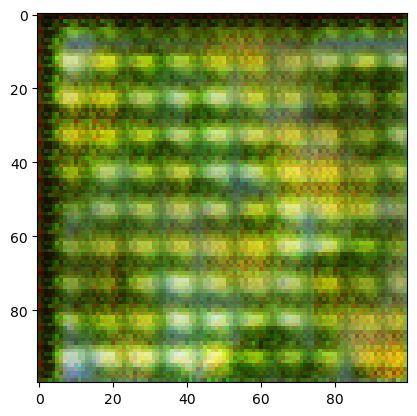

In [36]:
noise=  tf.random.normal([1, noise_shape],seed=randint(0,1000))
label = tf.Variable([20])

pred = acgan(noise,label)
plt.imshow((pred[0, :, :, :]+1)/2.0)
